In [1]:
import sys
sys.path.insert(0, "../..")
#%reload_ext autoreload
#%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import numpy
import spatialpy
print(spatialpy.__file__)

../../spatialpy/__init__.py


In [3]:
class Membrane(spatialpy.SubDomain):
    def __init__(self, radius_external, radius_internal):
        spatialpy.SubDomain.__init__(self)
        self.radius_external = radius_external
        self.radius_internal = radius_internal
        
    def inside(self, x, on_boundary):
        r = numpy.sqrt(x[0] * x[0] + x[1] * x[1])
        return self.radius_external >= r >= self.radius_internal
    
class Cytoplasm(spatialpy.SubDomain):
    def __init__(self, radius_external, radius_internal):
        spatialpy.SubDomain.__init__(self)
        self.radius_external = radius_external
        self.radius_internal = radius_internal
        
    def inside(self, x, on_boundary):
        r = numpy.sqrt(x[0] * x[0] + x[1] * x[1])
        return r < self.radius_internal
    
class GbgGradient(spatialpy.DataFunction):
    def __init__(self, Gbg_mid=5000, Gbg_slope=0.0, mem_vol=1.0):
        """ 1D domain from a to b. """
        spatialpy.DataFunction.__init__(self, name="GbgGradient")
        self.Gbg_mid = Gbg_mid
        self.Gbg_slope = Gbg_slope  # NM/um
        self.mem_vol = mem_vol
        
    def map(self, x):
        ret = self.Gbg_slope*x[2] + self.Gbg_mid
        return ret/self.mem_vol

In [4]:
class Cdc42_cycle_2D_SpatialPy_SDPD(spatialpy.Model):

    def __init__(self, model_name="Cdc42_2D",
                 end_time=None):
        spatialpy.Model.__init__(self,model_name)

        #################################################
        Gbg_conc=5000.0
        Gbg_pct_slope=0.0
        delta1_val=0.00297
        delta1_gbg_val=0.00297
        delta_neg_val=1.0/30000
        #################################################
        cell_radius = 2.0
        radius_external = 0.6
        radius_internal = 0.4

        self.mesh = spatialpy.Mesh.create_2D_domain([-1,1], [-1,1], 80,80)

        #self.add_subdomain(Membrane(radius_external, radius_internal), 2, mass=4.0, nu=1.0, fixed=False)
        self.add_subdomain(Membrane(radius_external, radius_internal), 2, mass=4.0, nu=1.0, fixed=False)
        self.add_subdomain(Cytoplasm(radius_external, radius_internal), 3, mass=2.0, nu=1.0, fixed=False)

        #################################################
        extra_cellular_volume = 0
        for voxel_index, voxel_coords in enumerate(self.mesh.coordinates()):
                if self.mesh.sd[voxel_index] == 1:
                    extra_cellular_volume = extra_cellular_volume + self.mesh.vol[voxel_index]
        membrane_volume = 0
        for voxel_index, voxel_coords in enumerate(self.mesh.coordinates()):
                if self.mesh.sd[voxel_index] == 2:
                    membrane_volume = membrane_volume + self.mesh.vol[voxel_index]
                    
        cytoplasm_volume = 0
        for voxel_index, voxel_coords in enumerate(self.mesh.coordinates()):
                if self.mesh.sd[voxel_index] == 3:
                    cytoplasm_volume = cytoplasm_volume + self.mesh.vol[voxel_index]
                    
        print("extra_cellular_volume",extra_cellular_volume)
        print("membrane_volume",membrane_volume)
        print("cytoplasm_volume",cytoplasm_volume)
        #################################################
        
        D_membrane = 0.0053   #diffusion on the membrane from PLOS paper
        D_GDP = 0.0053
        D_GTP = 0.0053
        D_bulk = 10.0
        
        # Species
        Cdc24_m = spatialpy.Species(name="Cdc24_m",  diffusion_constant=D_membrane)
        Cdc24_c = spatialpy.Species(name="Cdc24_c",  diffusion_constant=D_bulk)
        Cdc42   = spatialpy.Species(name="Cdc42",    diffusion_constant=D_GDP)
        Cdc42_a = spatialpy.Species(name="Cdc42_a",  diffusion_constant=D_GTP)
        Bem1_m  = spatialpy.Species(name="Bem1_m",   diffusion_constant=D_membrane)
        Bem1_c  = spatialpy.Species(name="Bem1_c",   diffusion_constant=D_bulk)
        Cla4    = spatialpy.Species(name="Cla4",     diffusion_constant=D_bulk)
        Cla4_a  = spatialpy.Species(name="Cla4_a",   diffusion_constant=D_membrane)
        Cdc42_c = spatialpy.Species(name="Cdc42_c",  diffusion_constant=D_bulk)
        self.add_species([Cdc24_m, Cdc24_c, Cdc42, Cdc42_a, Bem1_m, Bem1_c, Cla4, Cla4_a, Cdc42_c])

        #################################################
        # Parameters
        k_42d =   spatialpy.Parameter(name="k_42d", expression=1.0)
        k_42a =   spatialpy.Parameter(name="k_42a", expression=0.2)
        k_24cm1 = spatialpy.Parameter(name="k_24cm1", expression=delta1_val)
        k_24mc =  spatialpy.Parameter(name="k_24mc", expression=0.35) 
        k_B1mc =  spatialpy.Parameter(name="k_B1mc", expression=0.35)
        k_B1cm =  spatialpy.Parameter(name="k_B1cm", expression=0.2667)
        k_Cla4a = spatialpy.Parameter(name="k_Cla4a", expression=0.006)
        k_Cla4d = spatialpy.Parameter(name="k_Cla4d", expression=0.01)
        k_24d =   spatialpy.Parameter(name="k_24d", expression=delta_neg_val)

        beta1 = spatialpy.Parameter(name="beta1", expression=0.266) 
        beta2 = spatialpy.Parameter(name="beta2", expression=0.28)
        beta3 = spatialpy.Parameter(name="beta3", expression=1.0) 
        delta1_gbg = spatialpy.Parameter(name="delta1_gbg", expression=delta1_gbg_val)
        self.add_parameter([k_42a, k_42d, k_24cm1, k_24mc, k_B1mc, k_B1cm, k_Cla4a, k_Cla4d, k_24d,beta1, beta2, beta3,delta1_gbg])

        # Add Data Function to model the mating pheromone gradient.
        self.add_data_function(GbgGradient(Gbg_mid=Gbg_conc,Gbg_slope=Gbg_conc*Gbg_pct_slope/(cell_radius*2.0),mem_vol=membrane_volume))

        # Reactions
        CR0 = spatialpy.Reaction(name="CR0", reactants={Cdc24_c:1}, products={Cdc24_m:1}, propensity_function="delta1_gbg*Cdc24_c*GbgGradient*vol", restrict_to=2)
        CR1 = spatialpy.Reaction(name="CR1", reactants={Cdc24_c:1,Bem1_m:1}, products={Cdc24_m:1,Bem1_m:1},  rate=k_24cm1, restrict_to=2)
        CR2 = spatialpy.Reaction(name="CR2", reactants={Cdc24_m:1}, products={Cdc24_c:1}, rate=k_24mc, restrict_to=2)
        CR3 = spatialpy.Reaction(name="CR3", reactants={Cdc24_m:1,Cla4_a:1}, products={Cdc24_c:1,Cla4_a:1}, rate=k_24d, restrict_to=2)
        CR4 = spatialpy.Reaction(name="CR4", reactants={Cdc24_m:1,Cdc42:1}, products={Cdc24_m:1,Cdc42_a:1}, rate=k_42a, restrict_to=2)
        CR5 = spatialpy.Reaction(name="CR5", reactants={Cdc42_a:1}, products={Cdc42:1}, rate=k_42d, restrict_to=2)
        CR6 = spatialpy.Reaction(name="CR6", reactants={Cdc42_a:1,Bem1_c:1}, products={Cdc42_a:1,Bem1_m:1}, rate=k_B1cm, restrict_to=2)
        CR7 = spatialpy.Reaction(name="CR7", reactants={Bem1_m:1}, products={Bem1_c:1}, rate=k_B1mc, restrict_to=2)
        CR8 = spatialpy.Reaction(name="CR8", reactants={Cdc42_a:1,Cla4:1}, products={Cdc42_a:1,Cla4_a:1}, rate=k_Cla4a, restrict_to=2)
        CR9 = spatialpy.Reaction(name="CR9", reactants={Cla4_a:1}, products={Cla4:1}, rate=k_Cla4d, restrict_to=2)
        
        CR10 = spatialpy.Reaction(name="CR10", reactants={Cdc42_c:1}, products={Cdc42:1}, rate=beta2, restrict_to=2)
        CR11 = spatialpy.Reaction(name="CR11", reactants={Cdc42:1}, products={Cdc42_c:1}, rate=beta3, restrict_to=2)
        CR12 = spatialpy.Reaction(name="CR12", reactants={Cdc42_c:1,Cdc24_m:1}, products={Cdc42_a:1,Cdc24_m:1}, rate=beta1, restrict_to=2)
        self.add_reaction([CR0,CR1,CR2,CR3,CR4,CR5,CR6,CR7,CR8,CR9,CR10,CR11,CR12])
        
        self.restrict(species=Cdc24_c,listOfSubDomains=[3,2])
        self.restrict(species=Bem1_c,listOfSubDomains=[3,2])
        self.restrict(species=Cla4,listOfSubDomains=[3,2])
        self.restrict(species=Cdc24_m,listOfSubDomains=[2])
        self.restrict(species=Cdc42,listOfSubDomains=[2])
        self.restrict(species=Cdc42_a,listOfSubDomains=[2])
        self.restrict(species=Bem1_m,listOfSubDomains=[2])
        self.restrict(species=Cla4_a,listOfSubDomains=[2])
        self.restrict(species=Cdc42_c,listOfSubDomains=[3,2])
        
        # Scatter initial condition
        self.add_initial_condition(spatialpy.ScatterInitialCondition(Cdc42,2700,[3])) # 10000  
        self.add_initial_condition(spatialpy.ScatterInitialCondition(Cdc24_c,1000,[2])) # We have 2000 Cdc24, GDI model has 1000
        self.add_initial_condition(spatialpy.ScatterInitialCondition(Bem1_c,3000,[2]))
        self.add_initial_condition(spatialpy.ScatterInitialCondition(Cla4,5000,[2]))  # 5000
        self.add_initial_condition(spatialpy.ScatterInitialCondition(Cdc42_a,300,[3]))

        # allow point to move
        self.staticDomain = True
        
        if end_time is None:
            self.timespan(range(1000))
        else:
            if end_time >= 1.0:
                self.timespan(range(end_time))
            else:
                self.timespan(numpy.linspace(0,end_time,10))
            print("simulating to {0}s".format(end_time))

In [7]:
model = Cdc42_cycle_2D_SpatialPy_SDPD(end_time=5)

extra_cellular_volume 0
membrane_volume 0.6099999999999898
cytoplasm_volume 0.4924999999999923
simulating to 5s


In [6]:
%time result = model.run(debug_level=1)

Compiling Solver.  Build dir: /tmp/spatialpy_build_f3_wpwpg
Elapsed seconds: 11.90
*************** initialize_rdme ******************
Creating thread to process 800 particles
[WORKER 0] waiting to begin step 0
Creating thread to process 800 particles
[WORKER 1] waiting to begin step 0
Creating thread to process 800 particles
[WORKER 2] waiting to begin step 0
Creating thread to process 800 particles
[WORKER 3] waiting to begin step 0
Creating thread to process 800 particles
[WORKER 4] waiting to begin step 0
Creating thread to process 800 particles
[WORKER 5] waiting to begin step 0
Creating thread to process 800 particles
Creating thread to process 800 particles
[WORKER 6] waiting to begin step 0
Creating thread to update x-position index
[WORKER 7] waiting to begin step 0
Creating thread to create output files
[0] Starting the Sort Index threads
[SORT] begin sort
[0] Starting the Output threads
[OUT] start output_vtk__sync_step()
[OUT] done output_vtk__sync_step()
[OUT] start output_

In [8]:
Cdc42_vals = result.get_species("Cdc42_a")

read_step(0) opening '/tmp/spatialpy_result_53is5x3y/output0.vtk'
read_step(1) opening '/tmp/spatialpy_result_53is5x3y/output1.vtk'
read_step(2) opening '/tmp/spatialpy_result_53is5x3y/output2.vtk'
read_step(3) opening '/tmp/spatialpy_result_53is5x3y/output3.vtk'
read_step(4) opening '/tmp/spatialpy_result_53is5x3y/output4.vtk'
read_step(5) opening '/tmp/spatialpy_result_53is5x3y/output5.vtk'
read_step(6) opening '/tmp/spatialpy_result_53is5x3y/output6.vtk'
read_step(7) opening '/tmp/spatialpy_result_53is5x3y/output7.vtk'
read_step(8) opening '/tmp/spatialpy_result_53is5x3y/output8.vtk'
read_step(9) opening '/tmp/spatialpy_result_53is5x3y/output9.vtk'
read_step(10) opening '/tmp/spatialpy_result_53is5x3y/output10.vtk'
read_step(11) opening '/tmp/spatialpy_result_53is5x3y/output11.vtk'
read_step(12) opening '/tmp/spatialpy_result_53is5x3y/output12.vtk'
read_step(13) opening '/tmp/spatialpy_result_53is5x3y/output13.vtk'
read_step(14) opening '/tmp/spatialpy_result_53is5x3y/output14.vtk'


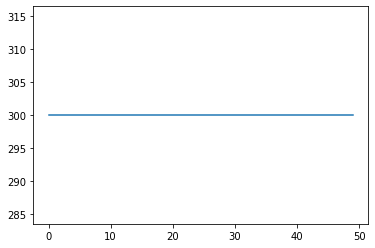

In [9]:
plt.plot(result.get_timespan(), Cdc42_vals.sum(axis=1))

In [10]:
result.display("Cdc42_a",0)

Exception: TODO

In [11]:
type_vals = result.get_property("type",0)

read_step(0) opening '/tmp/spatialpy_result_53is5x3y/output0.vtk'


In [12]:
def plot_step(t_ndx,key='type'):
    pts, data = result.read_step(t_ndx)
    plt.figure(figsize=(15,10) )
    plt.scatter(pts[:,0],pts[:,1],c=data[key])
    plt.axis('equal')
    plt.colorbar()
    plt.title('t={0}'.format(t_ndx))

read_step(0) opening '/tmp/spatialpy_result_53is5x3y/output0.vtk'
read_step(1) opening '/tmp/spatialpy_result_53is5x3y/output1.vtk'
read_step(2) opening '/tmp/spatialpy_result_53is5x3y/output2.vtk'
read_step(3) opening '/tmp/spatialpy_result_53is5x3y/output3.vtk'
read_step(4) opening '/tmp/spatialpy_result_53is5x3y/output4.vtk'


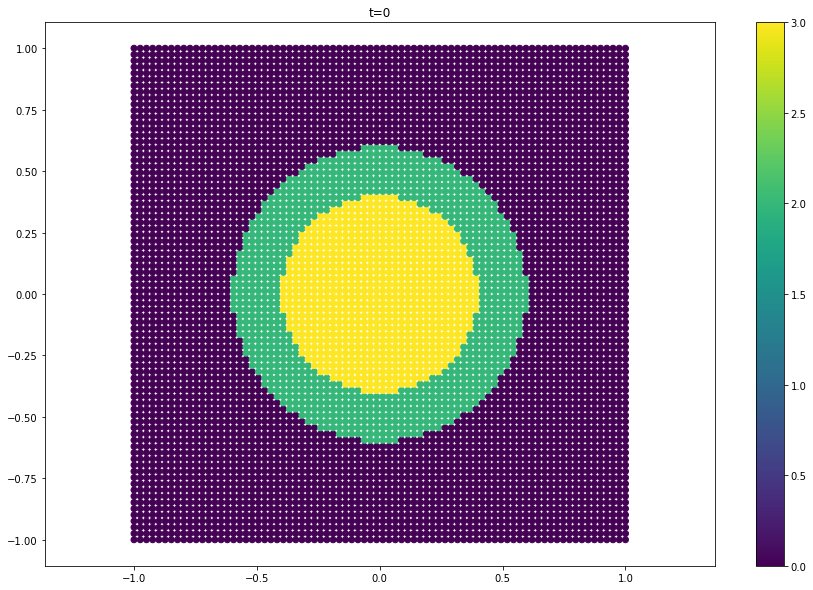

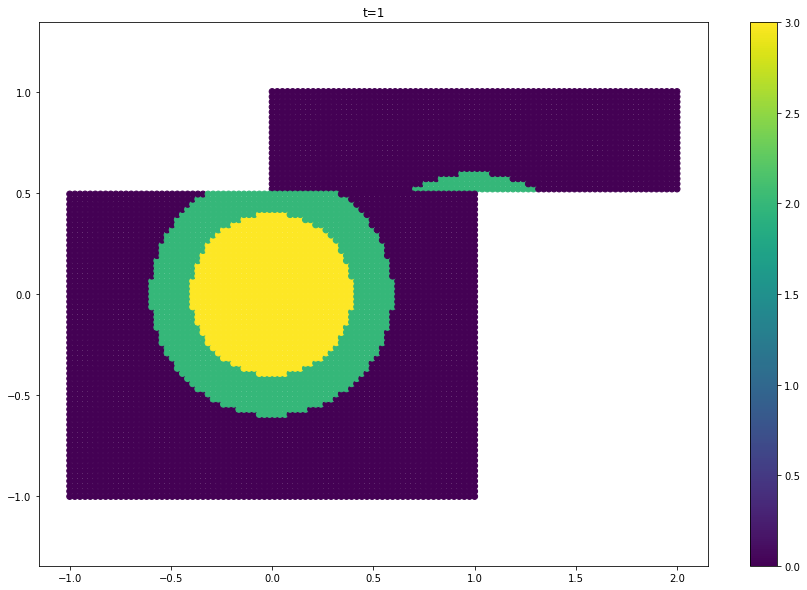

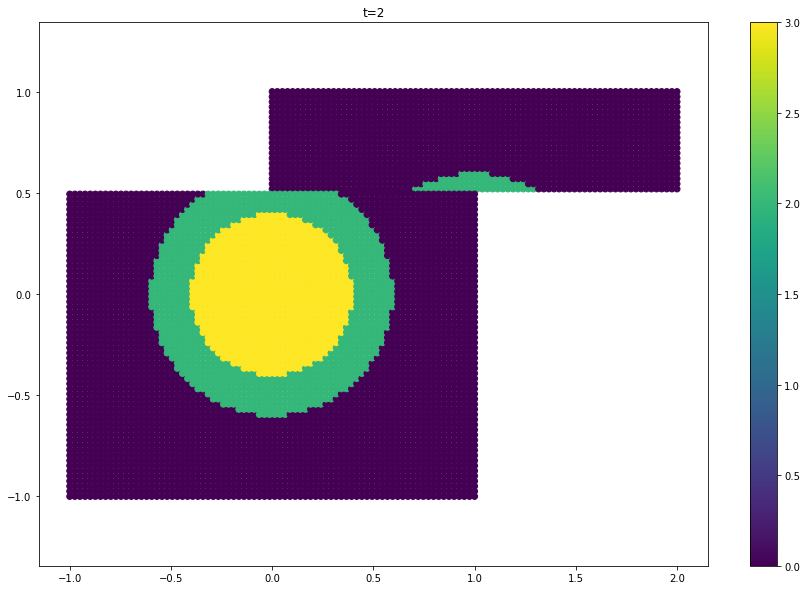

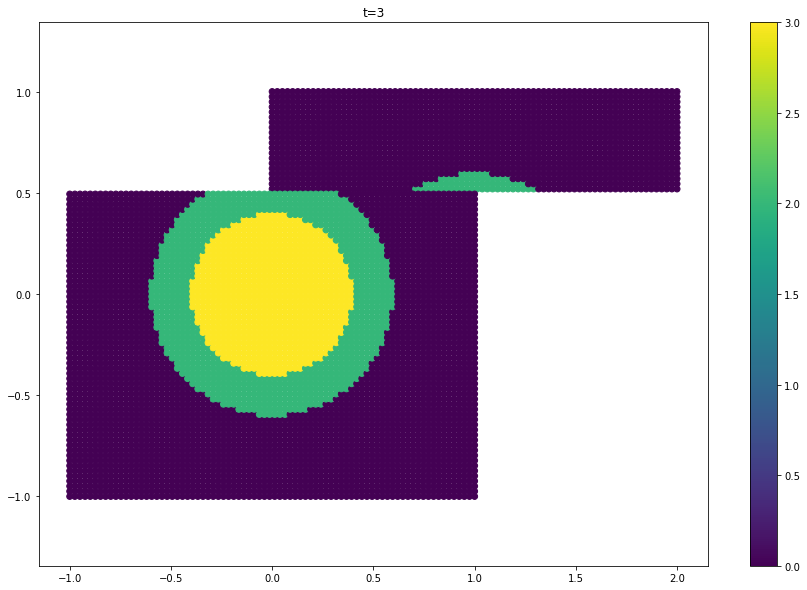

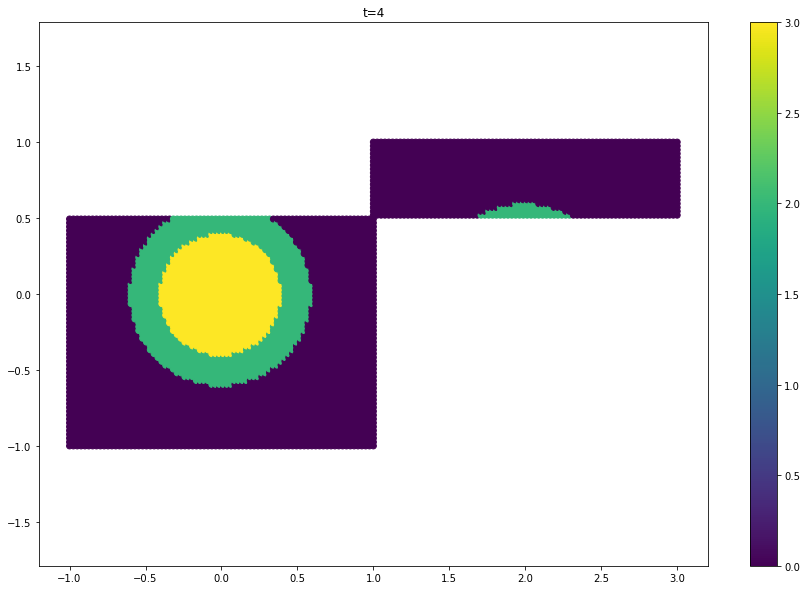

In [14]:
for i in range(0,5):
    #print(i)
    plot_step(i)

read_step(0) opening '/tmp/spatialpy_result_53is5x3y/output0.vtk'
read_step(1) opening '/tmp/spatialpy_result_53is5x3y/output1.vtk'
read_step(2) opening '/tmp/spatialpy_result_53is5x3y/output2.vtk'
read_step(3) opening '/tmp/spatialpy_result_53is5x3y/output3.vtk'
read_step(4) opening '/tmp/spatialpy_result_53is5x3y/output4.vtk'


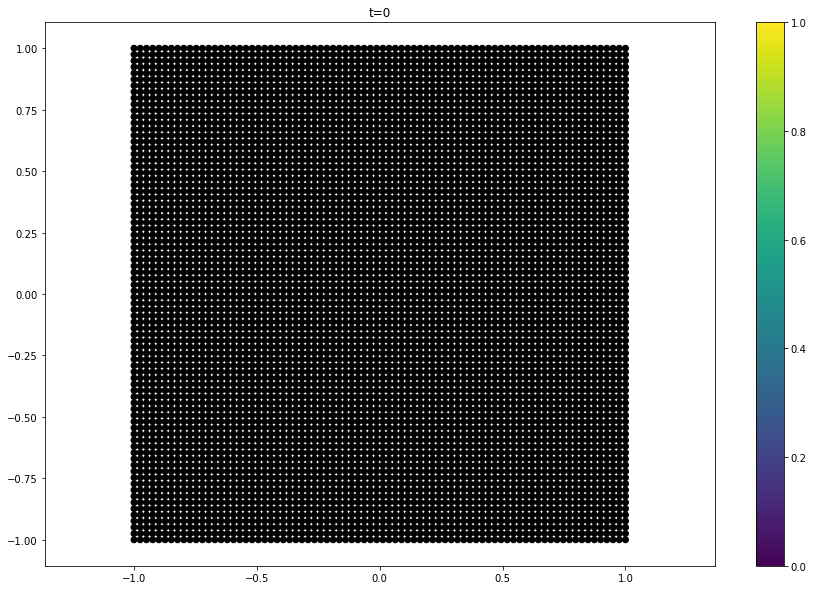

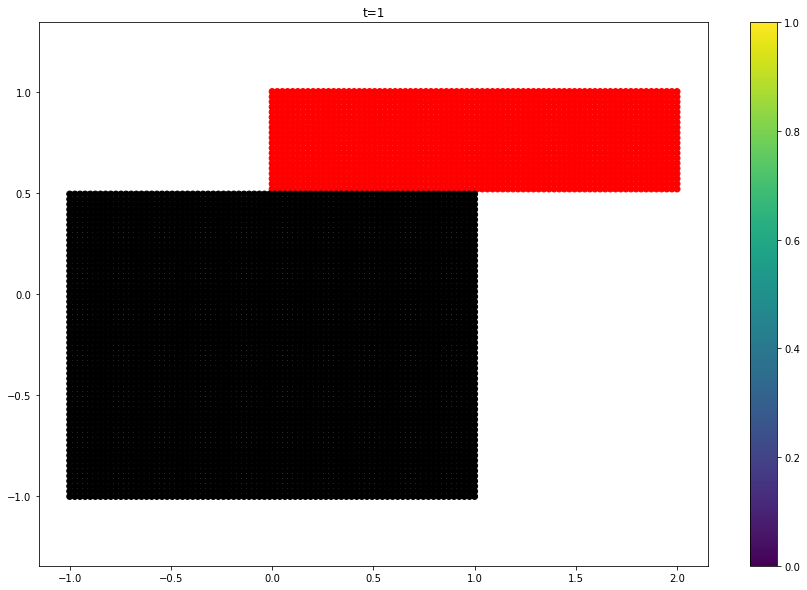

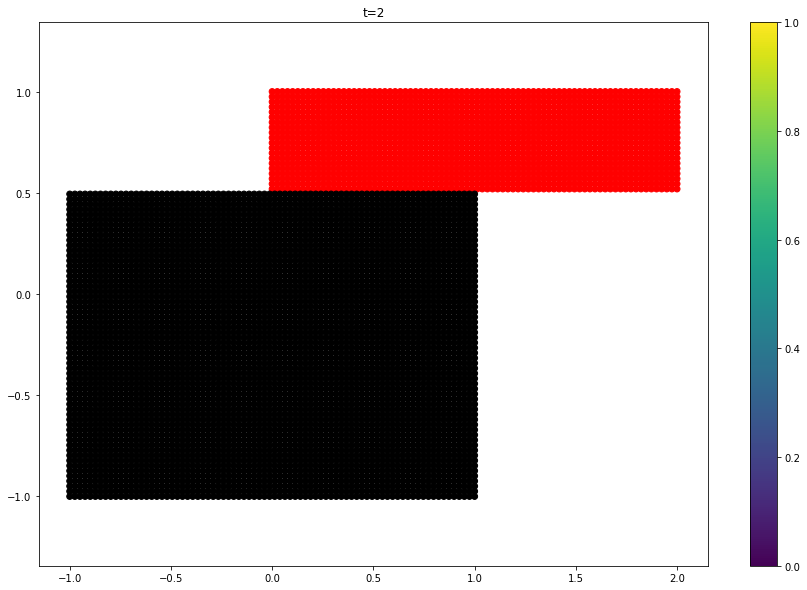

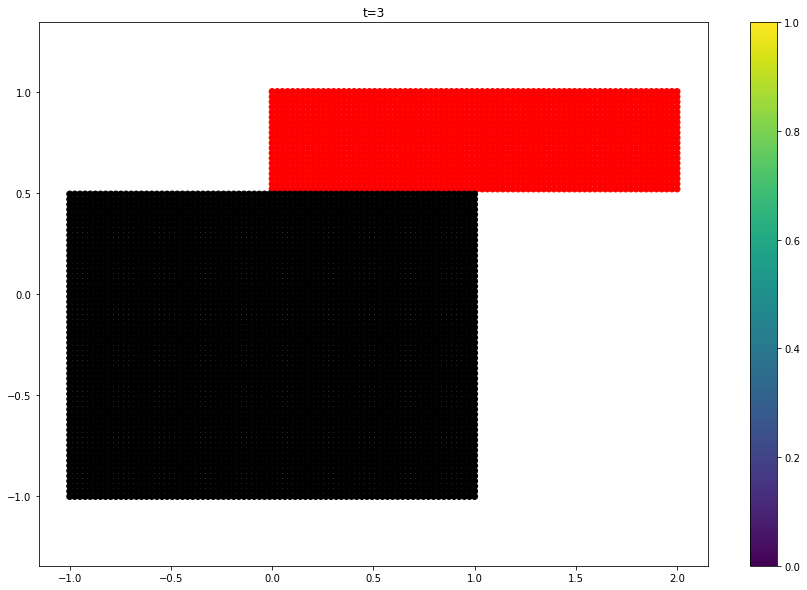

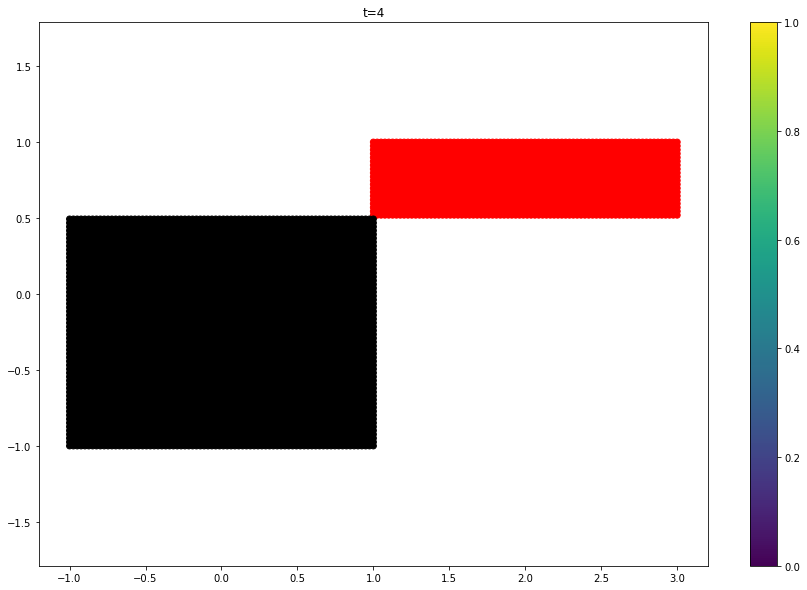

In [16]:
for i in range(0,5):
    #print(i)
    plot_step(i,'v')

In [15]:
from spatialpy.nsmsolver import NSMSolver
sol = NSMSolver(model, debug_level=2)
%time sol.compile()

Compiling Solver.  Build dir: /tmp/spatialpy_build_d49959m3
Creating propensity file /tmp/spatialpy_build_d49959m3/Cdc42_2D_generated_model.c
cmd: cd /tmp/spatialpy_build_d49959m3 ; make -f /home/brian/Desktop/research/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/build/Makefile.nsm ROOT=/home/brian/Desktop/research/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine MODEL=/tmp/spatialpy_build_d49959m3/Cdc42_2D_generated_model.c BUILD=/tmp/spatialpy_build_d49959m3

gcc -c -o linked_list.o /home/brian/Desktop/research/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/src/linked_list.c -I/home/brian/Desktop/research/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/include/ -O3 -Wall 
gcc -c -o particle.o /home/brian/Desktop/research/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/src/particle.c -I/home/brian/Desktop/research/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/include/ -O3 -Wall 
gcc -c -o simulate.o /home/brian/Desktop/research/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engi